In [3]:
%load_ext autoreload
%autoreload 2

from fastai.text.all import *
from fastai.vision.all import *
import pandas as pd
import torch
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report, f1_score
from torchcrf import CRF
from utils import get_sequences, GetLabels, My_Pad_Input

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
seed = 42

# python RNG
import random
random.seed(seed)

# pytorch RNGs
import torch
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

# numpy RNG
import numpy as np
np.random.seed(seed)

In [5]:
OUT_DIM=12
INPUT_DIM=128
BS= 64

In [6]:
train = pd.read_csv("./data/train_fusion.csv")
val = pd.read_csv("./data/val_fusion.csv")
test_data = pd.read_csv("./data/test_fusion.csv")

In [7]:
train["document_type"] = train.apply(lambda x: "B-" + x["document_type"] if x["pages"] == 1 else "I-" + x["document_type"],
                                     axis=1)
val["document_type"] = val.apply(lambda x: "B-" + x["document_type"] if x["pages"] == 1 else "I-" + x["document_type"],
                                     axis=1)
test_data["document_type"] = test_data.apply(lambda x: "B-" + x["document_type"] if x["pages"] == 1 else "I-" + x["document_type"],
                                   axis=1)

In [8]:
X_train, y_train = get_sequences(train)
X_valid, y_valid = get_sequences(val)
X_test, y_test = get_sequences(test_data)

In [9]:
data = pd.concat([pd.DataFrame({"acts":X_train, "labels":y_train, "is_valid": False}),
                 pd.DataFrame({"acts":X_valid, "labels":y_valid, "is_valid": True})])

In [10]:
class GetFusionActs(Transform):
    def encodes(self, x):    
        acts = []
        for act in x["acts"]:
            acts.append(torch.load(act.replace("text", "fusion") + ".pt").unsqueeze(0)) 
        return torch.cat(acts)

In [11]:
my_pad_input=My_Pad_Input(12)

In [19]:
tfms = [[GetFusionActs()], [GetLabels()]]
splits = ColSplitter()(data)
dsets = Datasets(data, tfms, splits=splits)
dls = dsets.dataloaders(dl_type=SortedDL, before_batch=partial(my_pad_input, pad_fields=[0,1]), bs=BS)

In [ ]:
dls.one_batch()

In [20]:
torch.save(dls, "./data/dls_sequence.pth")

In [12]:
dls = torch.load("./data/dls_sequence.pth")

In [21]:
class SequenceModel(Module):
    def __init__(self, input_dim, out_dim, hidden_dim=128):
        self.lstm = torch.nn.LSTM(input_size=input_dim, hidden_size=hidden_dim,
                                  batch_first=True, bidirectional=True).cuda()
        self.bn = nn.BatchNorm1d(hidden_dim*2, momentum=0.01).cuda()
        self.drop = nn.Dropout().cuda()
        self.lin = nn.Linear(hidden_dim*2, out_dim).cuda()
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out.permute(0, 2, 1)
        out_norm = self.bn(out)
        out_drop = self.drop(out_norm)
        out_drop = out_drop.permute(0, 2, 1)
        return self.lin(out_drop)

In [22]:
model = SequenceModel(128, 12)

In [23]:
def loss_func(out, targ):
    return CrossEntropyLossFlat(ignore_index=OUT_DIM)(out, targ.long())

In [24]:
def _accumulate(self, learn):
    pred = learn.pred
    targ = learn.y
    pred,targ = to_detach(pred),to_detach(targ)
    pred =np.argmax(pred, axis=-1)
    pred, targ = flatten_check(pred, targ)
    pad_idxs = [i for i,x in enumerate(targ) if x != tensor([12])]
    pred = pred[pad_idxs]
    targ = targ[pad_idxs]
    pred = torch.remainder(pred, 6)
    targ = torch.remainder(targ, 6)
    self.preds.append(pred)
    self.targs.append(targ)

AccumMetric.accumulate = _accumulate

def MyFScore(average='macro'):
    return skm_to_fastai(f1_score, average=average)

In [25]:
learn = Learner(dls, model, loss_func=loss_func, metrics=[MyFScore()])

In [26]:
learn.summary()

SequenceModel (Input shape: ['64 x 4242 x 128'])
Layer (type)         Output Shape         Param #    Trainable 
LSTM                 ['64 x 4242 x 256',  264,192    True      
________________________________________________________________
BatchNorm1d          64 x 256 x 4242      512        True      
________________________________________________________________
Dropout              64 x 256 x 4242      0          False     
________________________________________________________________
Linear               64 x 4242 x 12       3,084      True      
________________________________________________________________

Total params: 267,788
Total trainable params: 267,788
Total non-trainable params: 0

Optimizer used: <function Adam at 0x7fd07c9f54c0>
Loss function: <function loss_func at 0x7fd06753a5e0>

Callbacks:
  - TrainEvalCallback
  - Recorder
  - ProgressCallback

In [27]:
learn.validate()

(#2) [2.5863826274871826,0.049502885806878415]

SuggestedLRs(lr_min=0.025118863582611083, lr_steep=0.03981071710586548)

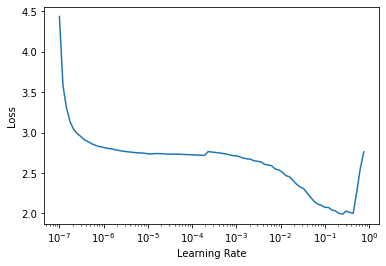

In [28]:
learn.lr_find()

In [29]:
learn.add_cbs([SaveModelCallback(monitor='f1_score', fname='best_sequence_128'),
                                       ShowGraphCallback()])

epoch,train_loss,valid_loss,f1_score,time
0,1.961057,1.081553,0.610358,03:36
1,1.051916,0.741459,0.325666,04:25
2,0.778732,0.678201,0.522402,04:16
3,0.650243,0.632359,0.546386,04:31
4,0.595360,0.850648,0.606682,04:12
5,0.529355,0.692955,0.573457,04:01
6,0.571075,1.102272,0.660538,04:18
7,0.534762,0.795043,0.730020,04:10
8,0.477003,0.742114,0.763850,04:11
9,0.437202,0.715917,0.769394,04:07


Better model found at epoch 0 with f1_score value: 0.6103582659377209.


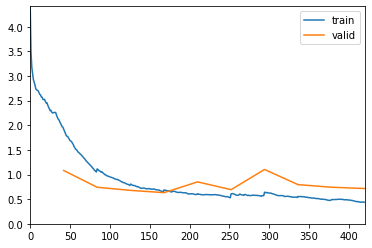

Better model found at epoch 6 with f1_score value: 0.6605381629039412.
Better model found at epoch 7 with f1_score value: 0.7300203646811069.
Better model found at epoch 8 with f1_score value: 0.7638503360387231.
Better model found at epoch 9 with f1_score value: 0.7693939408255023.


In [30]:
learn.fit_one_cycle(10, lr_max=1e-2)

In [31]:
model = SequenceModel(128, 12, hidden_dim=256)

In [32]:
learn = Learner(dls, model, loss_func=loss_func, metrics=[MyFScore()])

In [33]:
learn.summary()

SequenceModel (Input shape: ['64 x 4242 x 128'])
Layer (type)         Output Shape         Param #    Trainable 
LSTM                 ['64 x 4242 x 512',  790,528    True      
________________________________________________________________
BatchNorm1d          64 x 512 x 4242      1,024      True      
________________________________________________________________
Dropout              64 x 512 x 4242      0          False     
________________________________________________________________
Linear               64 x 4242 x 12       6,156      True      
________________________________________________________________

Total params: 797,708
Total trainable params: 797,708
Total non-trainable params: 0

Optimizer used: <function Adam at 0x7fd07c9f54c0>
Loss function: <function loss_func at 0x7fd06753a5e0>

Callbacks:
  - TrainEvalCallback
  - Recorder
  - ProgressCallback

SuggestedLRs(lr_min=0.03630780577659607, lr_steep=0.019054606556892395)

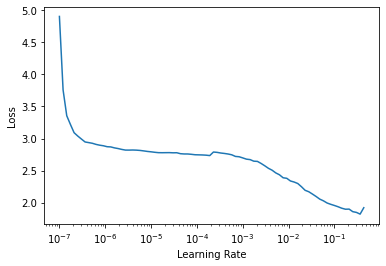

In [34]:
learn.lr_find()

In [35]:
learn.add_cbs([SaveModelCallback(monitor='f1_score', fname='best_sequence_256'),
                                       ShowGraphCallback()])

epoch,train_loss,valid_loss,f1_score,time
0,1.738328,0.706088,0.597457,03:43
1,1.050031,0.635543,0.425321,03:49
2,0.854596,2.389529,0.507217,04:12
3,0.712987,0.630090,0.535214,04:03
4,0.616051,1.110406,0.506089,04:15
5,0.556068,0.670646,0.755296,04:04
6,0.514513,0.671462,0.725564,04:02
7,0.474921,0.686596,0.754778,04:23
8,0.454099,0.659062,0.763931,04:15
9,0.439986,0.660476,0.770568,04:09


Better model found at epoch 0 with f1_score value: 0.5974572802351404.


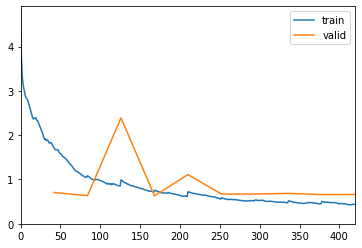

Better model found at epoch 5 with f1_score value: 0.7552957386895588.
Better model found at epoch 8 with f1_score value: 0.7639306937349533.
Better model found at epoch 9 with f1_score value: 0.7705676184137128.


In [36]:
learn.fit_one_cycle(10, lr_max=1e-2)

In [37]:
model = SequenceModel(128, 12)

In [38]:
learn = Learner(dls, model, loss_func=loss_func, metrics=[MyFScore()])

In [39]:
learn.summary()

SequenceModel (Input shape: ['64 x 4242 x 128'])
Layer (type)         Output Shape         Param #    Trainable 
LSTM                 ['64 x 4242 x 256',  264,192    True      
________________________________________________________________
BatchNorm1d          64 x 256 x 4242      512        True      
________________________________________________________________
Dropout              64 x 256 x 4242      0          False     
________________________________________________________________
Linear               64 x 4242 x 12       3,084      True      
________________________________________________________________

Total params: 267,788
Total trainable params: 267,788
Total non-trainable params: 0

Optimizer used: <function Adam at 0x7fd07c9f54c0>
Loss function: <function loss_func at 0x7fd06753a5e0>

Callbacks:
  - TrainEvalCallback
  - Recorder
  - ProgressCallback

SuggestedLRs(lr_min=0.03019951581954956, lr_steep=0.2089296132326126)

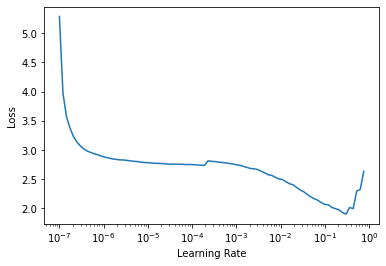

In [40]:
learn.lr_find()

In [41]:
learn.add_cbs([SaveModelCallback(monitor='f1_score', fname='best_sequence_128_more_epochs'),
                                       ShowGraphCallback()])

epoch,train_loss,valid_loss,f1_score,time
0,21.824802,39.532612,0.783157,04:33
1,21.640242,40.254009,0.784706,04:17
2,21.259405,39.345985,0.779711,04:47
3,21.476702,42.383537,0.779622,04:17
4,23.249653,40.144146,0.777574,04:25
5,25.783693,50.547745,0.781810,04:14
6,26.843296,40.940971,0.780256,04:31
7,22.409956,39.435081,0.783081,04:19
8,20.038574,39.131020,0.780873,04:25
9,19.074781,37.723991,0.785197,04:16


Better model found at epoch 0 with f1_score value: 0.783156751761378.


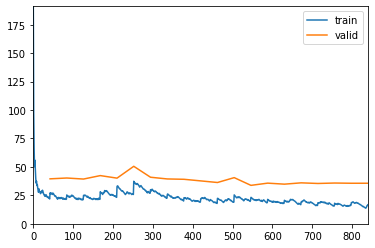

Better model found at epoch 1 with f1_score value: 0.7847055781112694.
Better model found at epoch 9 with f1_score value: 0.7851965440420884.
Better model found at epoch 11 with f1_score value: 0.7862494999451309.
Better model found at epoch 13 with f1_score value: 0.7868117598336918.
Better model found at epoch 15 with f1_score value: 0.7885034163592466.


In [74]:
learn.fit_one_cycle(20, lr_max=1e-3)

In [43]:
learn.load("best_sequence_128_more_epochs")

In [44]:
def evaluate(learn, dl):
    preds, targets = learn.get_preds(dl=dl)
    preds =[np.argmax(x, axis=-1) for sublist in preds for x in sublist]
    targets = [x for sublist in targets for x in sublist]
    pad_idxs = [i for i,x in enumerate(targets) if x != tensor([12])]
    preds = L(preds)[pad_idxs]
    targets = L(targets)[pad_idxs]
    print(classification_report(targets, preds, target_names=dl.get_labels.cat.vocab, digits=4))
    preds = [x % 6 for x in preds]
    targets = [x % 6 for x in targets]
    print(classification_report(targets, preds, target_names=[x[2:] for x in dl.get_labels.cat.vocab[:6]], digits=4))

In [45]:
evaluate(learn, dls.valid)

                                    precision    recall  f1-score   support

          B-acordao_de_2_instancia     0.9189    0.6766    0.7794       201
B-agravo_em_recurso_extraordinario     0.4167    0.0211    0.0402       237
     B-despacho_de_admissibilidade     0.6645    0.6871    0.6756       147
                          B-outros     0.7138    0.6261    0.6671     25898
                   B-peticao_do_RE     0.1429    0.0031    0.0060       326
                        B-sentenca     0.7820    0.3662    0.4988       284
          I-acordao_de_2_instancia     0.4750    0.5816    0.5229        98
I-agravo_em_recurso_extraordinario     0.5706    0.5539    0.5621      1912
     I-despacho_de_admissibilidade     0.0000    0.0000    0.0000        36
                          I-outros     0.8070    0.8533    0.8295     58206
                   I-peticao_do_RE     0.6966    0.7844    0.7379      6038
                        I-sentenca     0.7861    0.7204    0.7518      1352

          

In [46]:
test_data = pd.DataFrame({"acts":X_test, "labels":y_test})

In [47]:
test_dl = dls.test_dl(test_data, with_labels=True)

In [48]:
torch.save(test_dl, "./data/test_dl_sequence.pth")

In [49]:
test_dl = torch.load("./data/test_dl_sequence.pth")

In [50]:
evaluate(learn, test_dl)

                                    precision    recall  f1-score   support

          B-acordao_de_2_instancia     0.9456    0.6985    0.8035       199
B-agravo_em_recurso_extraordinario     0.3750    0.0282    0.0524       213
     B-despacho_de_admissibilidade     0.5833    0.6190    0.6007       147
                          B-outros     0.7005    0.6256    0.6609     25744
                   B-peticao_do_RE     0.2000    0.0032    0.0063       312
                        B-sentenca     0.7480    0.3472    0.4742       265
          I-acordao_de_2_instancia     0.4255    0.8108    0.5581        74
I-agravo_em_recurso_extraordinario     0.5548    0.5442    0.5495      1628
     I-despacho_de_admissibilidade     0.3333    0.0196    0.0370        51
                          I-outros     0.8124    0.8546    0.8330     59664
                   I-peticao_do_RE     0.7229    0.7712    0.7463      6019
                        I-sentenca     0.7754    0.7446    0.7597      1210

          

### With CRF

In [51]:
class BiLSTMCRF(Module):
    def __init__(self, hidden_dim=128, out_dim=OUT_DIM):
        self.lstm = torch.nn.LSTM(input_size=INPUT_DIM, hidden_size=hidden_dim,
                                  batch_first=True, bidirectional=True).cuda()
        self.bn = nn.BatchNorm1d(hidden_dim*2, momentum=0.01).cuda()
        self.drop = nn.Dropout().cuda()
        self.lin = nn.Linear(hidden_dim*2, out_dim).cuda()
        self.crf = CRF(num_tags=OUT_DIM, batch_first=True).cuda()
            
    def crf_loss_func(self, out, targ):
        mask = tensor(targ.data != OUT_DIM)
        clean_targ = targ.clone()
        clean_targ[clean_targ==OUT_DIM]=0
        targ=targ.view(out.shape[:2])
        clean_targ=clean_targ.view(targ.shape)
        mask=mask.view(targ.shape)
        return -self.crf(out, clean_targ.long(), mask=mask, reduction="mean")
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out.permute(0, 2, 1)
        out_norm = self.bn(out)
        out_drop = self.drop(out_norm)
        out_drop = out_drop.permute(0, 2, 1)
        logits = self.lin(out_drop)
        return logits

In [52]:
model = BiLSTMCRF()

In [53]:
def _accumulate(self, learn):
    pred = learn.pred
    targ = learn.y
    mask = tensor(targ.data != OUT_DIM)
    pred,targ, mask = to_detach(pred),to_detach(targ), to_detach(mask)
    mask=mask.view(pred.shape[:2])
    pred = learn.model.crf.decode(pred.cuda(),mask=mask.cuda())
    pred = tensor([[x for sublist in pred for x in sublist]]).view(-1)
    targ = targ[mask].view(-1)
    pred = torch.remainder(pred, 6)
    targ = torch.remainder(targ, 6)
    self.preds.append(pred)
    self.targs.append(targ)

AccumMetric.accumulate = _accumulate

def MyFScore(average='macro'):
    return skm_to_fastai(f1_score, average=average)

In [54]:
learn = Learner(dls, model, loss_func=model.crf_loss_func, metrics=[MyFScore()])

In [55]:
learn.validate()

(#2) [130.3740692138672,0.05782180110321647]

In [56]:
learn.summary()

BiLSTMCRF (Input shape: ['64 x 4242 x 128'])
Layer (type)         Output Shape         Param #    Trainable 
LSTM                 ['64 x 4242 x 256',  264,192    True      
________________________________________________________________
BatchNorm1d          64 x 256 x 4242      512        True      
________________________________________________________________
Dropout              64 x 256 x 4242      0          False     
________________________________________________________________
Linear               64 x 4242 x 12       3,084      True      
________________________________________________________________

Total params: 267,788
Total trainable params: 267,788
Total non-trainable params: 0

Optimizer used: <function Adam at 0x7fd07c9f54c0>
Loss function: <bound method BiLSTMCRF.crf_loss_func of BiLSTMCRF(
  (lstm): LSTM(128, 128, batch_first=True, bidirectional=True)
  (bn): BatchNorm1d(256, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (drop): Dropout(p

SuggestedLRs(lr_min=0.017378008365631102, lr_steep=7.585775847473997e-07)

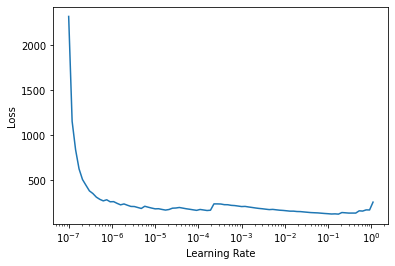

In [57]:
learn.lr_find()

In [58]:
learn.add_cbs([SaveModelCallback(monitor='f1_score', fname='best_lstm_crf_128'),
                                       ShowGraphCallback()])

epoch,train_loss,valid_loss,f1_score,time
0,149.831329,110.851990,0.252063,03:21
1,120.070366,62.507153,0.625379,04:05
2,83.046822,46.854389,0.648202,04:14
3,62.531319,42.626644,0.698233,04:36
4,50.549274,45.847187,0.723074,04:11
5,43.849651,39.024208,0.742153,04:16
6,36.382923,40.039272,0.759703,04:18
7,32.807117,40.211197,0.767431,04:25
8,31.406328,41.065979,0.763717,04:22
9,29.223454,42.091816,0.762038,04:20


Better model found at epoch 0 with f1_score value: 0.25206293624567744.


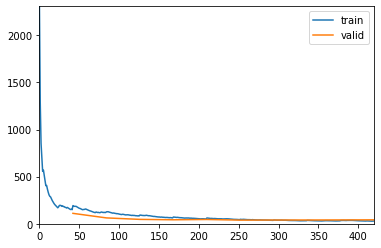

Better model found at epoch 1 with f1_score value: 0.6253790011711321.
Better model found at epoch 2 with f1_score value: 0.6482016650865791.
Better model found at epoch 3 with f1_score value: 0.6982331387013132.
Better model found at epoch 4 with f1_score value: 0.7230737998211398.
Better model found at epoch 5 with f1_score value: 0.7421530750538744.
Better model found at epoch 6 with f1_score value: 0.7597028083162276.
Better model found at epoch 7 with f1_score value: 0.7674312612526871.


In [59]:
learn.fit_one_cycle(10, lr_max=1e-3)

In [60]:
model = BiLSTMCRF(hidden_dim=256)

In [61]:
learn = Learner(dls, model, loss_func=model.crf_loss_func, metrics=[MyFScore()])

SuggestedLRs(lr_min=0.02089296132326126, lr_steep=1.0964781722577754e-06)

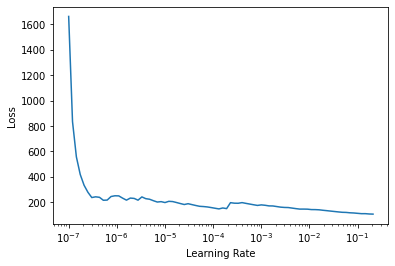

In [62]:
learn.lr_find()

In [63]:
learn.add_cbs([SaveModelCallback(monitor='f1_score', fname='best_lstm_crf_256'),
                                       ShowGraphCallback()])

epoch,train_loss,valid_loss,f1_score,time
0,134.512543,85.542542,0.469704,03:57
1,90.833908,43.927441,0.711424,04:21
2,68.291672,37.831848,0.726812,04:21
3,50.566601,61.461323,0.725289,04:24
4,46.711521,38.017696,0.758176,04:14
5,36.325333,36.228466,0.768638,04:11
6,31.310980,37.981602,0.775473,04:17
7,26.603998,36.238197,0.771468,04:16
8,25.199459,39.141491,0.772091,04:27
9,23.588184,40.136883,0.771817,04:06


Better model found at epoch 0 with f1_score value: 0.4697038971861604.


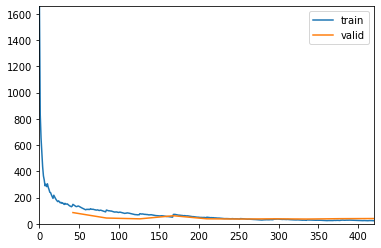

Better model found at epoch 1 with f1_score value: 0.7114241621453211.
Better model found at epoch 2 with f1_score value: 0.7268115678137878.
Better model found at epoch 4 with f1_score value: 0.7581757623316677.
Better model found at epoch 5 with f1_score value: 0.7686379328546765.
Better model found at epoch 6 with f1_score value: 0.7754725050181825.


In [64]:
learn.fit_one_cycle(10, lr_max=1e-3)

In [65]:
model = BiLSTMCRF()

In [66]:
learn = Learner(dls, model, loss_func=model.crf_loss_func, metrics=[MyFScore()])

In [67]:
learn.add_cbs([SaveModelCallback(monitor='f1_score', fname='best_lstm_crf_128_moreEpochs'),
                                       ShowGraphCallback()])

epoch,train_loss,valid_loss,f1_score,time
0,163.592941,119.275978,0.119657,04:09
1,138.501572,88.850716,0.415338,04:16
2,108.193100,55.273426,0.629308,04:16
3,80.029839,41.503017,0.682463,04:24
4,58.973175,38.506977,0.703839,03:57
5,51.819187,36.713329,0.706103,04:17
6,41.449135,39.236824,0.733006,04:26
7,35.807060,36.552204,0.751018,04:21
8,32.086254,42.414913,0.773632,04:28
9,32.035362,37.080910,0.772853,04:21


Better model found at epoch 0 with f1_score value: 0.11965685386936246.


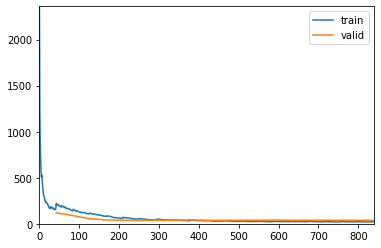

Better model found at epoch 1 with f1_score value: 0.4153377938213973.
Better model found at epoch 2 with f1_score value: 0.6293081734276357.
Better model found at epoch 3 with f1_score value: 0.6824625577905539.
Better model found at epoch 4 with f1_score value: 0.7038385959606025.
Better model found at epoch 5 with f1_score value: 0.7061031939183403.
Better model found at epoch 6 with f1_score value: 0.7330055584498351.
Better model found at epoch 7 with f1_score value: 0.7510175949877235.
Better model found at epoch 8 with f1_score value: 0.7736317973148504.
Better model found at epoch 10 with f1_score value: 0.7793476301399087.
Better model found at epoch 11 with f1_score value: 0.7814525311850042.
Better model found at epoch 12 with f1_score value: 0.7845339767969008.


In [68]:
learn.fit_one_cycle(20, lr_max=1e-3)

In [69]:
learn.load("best_lstm_crf_128_moreEpochs")

In [70]:
def evaluate_crf(learn, dl):
    preds, targets = learn.get_preds(dl=dl)
    crf_preds =[]
    crf_targs=[]
    for pred, targ in zip(preds, targets):
        pred = pred.unsqueeze(0)
        targ = targ.unsqueeze(0)
        mask = tensor(targ.data != OUT_DIM)
        mask=mask.view(pred.shape[:2])
        pred = learn.model.crf.decode(pred.cuda(),mask=mask.cuda())
        pred = tensor([[x for sublist in pred for x in sublist]]).view(-1)
        targ = targ[mask].view(-1)
        crf_preds.append(pred)
        crf_targs.append(targ)
    crf_preds = torch.cat(crf_preds)
    crf_targs = torch.cat(crf_targs)
    print(classification_report(crf_targs, crf_preds, target_names=dls.get_labels.cat.vocab, digits=4))
    crf_preds = torch.remainder(crf_preds, 6)
    crf_targs = torch.remainder(crf_targs, 6)
    print(classification_report(crf_targs, crf_preds, target_names=dls.get_labels.cat.vocab[:6], digits=4))
    

In [71]:
evaluate_crf(learn, dls.valid)

                                    precision    recall  f1-score   support

          B-acordao_de_2_instancia     0.8839    0.6816    0.7697       201
B-agravo_em_recurso_extraordinario     0.0500    0.0042    0.0078       237
     B-despacho_de_admissibilidade     0.7067    0.7211    0.7138       147
                          B-outros     0.9086    0.5258    0.6661     25898
                   B-peticao_do_RE     0.5506    0.1503    0.2361       326
                        B-sentenca     0.6875    0.1162    0.1988       284
          I-acordao_de_2_instancia     0.5000    0.5612    0.5288        98
I-agravo_em_recurso_extraordinario     0.5676    0.5685    0.5681      1912
     I-despacho_de_admissibilidade     0.0000    0.0000    0.0000        36
                          I-outros     0.7898    0.9415    0.8590     58206
                   I-peticao_do_RE     0.7207    0.7796    0.7490      6038
                        I-sentenca     0.7617    0.7589    0.7603      1352

          

In [72]:
test_dl = torch.load("./data/test_dl_sequence.pth")

In [73]:
evaluate_crf(learn, test_dl)

                                    precision    recall  f1-score   support

          B-acordao_de_2_instancia     0.9205    0.6985    0.7943       199
B-agravo_em_recurso_extraordinario     0.1429    0.0094    0.0176       213
     B-despacho_de_admissibilidade     0.6294    0.6122    0.6207       147
                          B-outros     0.8934    0.5161    0.6543     25744
                   B-peticao_do_RE     0.5393    0.1538    0.2394       312
                        B-sentenca     0.7170    0.1434    0.2390       265
          I-acordao_de_2_instancia     0.4833    0.7838    0.5979        74
I-agravo_em_recurso_extraordinario     0.5433    0.5584    0.5507      1628
     I-despacho_de_admissibilidade     0.0000    0.0000    0.0000        51
                          I-outros     0.7932    0.9445    0.8622     59664
                   I-peticao_do_RE     0.7486    0.7619    0.7552      6019
                        I-sentenca     0.7587    0.7769    0.7677      1210

          